# Bibliotecas:

In [1]:
import os
from pyhdf.SD import SD, SDC
import pandas as pd
import json
from processamento_dados import (selecao_area,
                                 controle_qualidade, porcentagem_valida,
                                 calc_media_espacial,
                                 calc_media_sazonal_1d, calc_media_sazonal_2d,
                                 calc_media_sazonal_anual_1d, calc_media_sazonal_anual_2d,
                                 convert_dicionario_1d_dataframe, convert_dicionario_2d_dataframe,
                                 preenchendo_dados,  calc_soma_deteccoes_coluna,hdf_path)
from plot_graficos import (plot_media_deteccoes_1d, plot_deteccoes_sazonais_2d, plot_coeficiente_extincao,
                           plot_multiplo_perfil_deteccao, plots_multiplos_perfil_ce_eoa,
                           plot_media_movel_deteccoes_eoa, plot_media_movel_deteccoes_2d)


# Importação dos dados:

In [2]:
perg = input('Qual o diretório?\n')

if perg == 'lasa':
    dir1 = r'C:\\Users\\amori\\OneDrive\\Documentos\\LASA\\Dados\\L2_VFM'
    dir2 = r'C:\Users\amori\OneDrive\Documentos\LASA\Dados\download_L3'
    
if perg == 'casa':
    dir1 = r'D:\Estudo\LASA\Dados\Bahia\L2_VFM'
    dir2 = r'D:\Estudo\LASA\Dados\Bahia\L3_Total'

Qual o diretório?
casa


In [3]:
# Inervalo de Tempo:
ano_inicial = input('Data de Inicio(Ano): ')
ano_final = input('Data de Final(Ano): ')

    
if ano_inicial == '':
    ano_inicial = '2006'
    
elif int(ano_inicial) < 2006:
    print('Não existe valores anteriores a 2006')

    
if ano_final == '':
    ano_final = '2022'
    
elif int(ano_final) > 2022:
    print('Não existe valores maiores que 2022')

files = hdf_path(dir2, [ano_inicial,ano_final])

Data de Inicio(Ano): 
Data de Final(Ano): 


In [4]:
files

['D:\\Estudo\\LASA\\Dados\\Bahia\\L3_Total\\CAL_LID_L3_Tropospheric_APro_AllSky-Standard-V4-20.2006-06N.hdf',
 'D:\\Estudo\\LASA\\Dados\\Bahia\\L3_Total\\CAL_LID_L3_Tropospheric_APro_AllSky-Standard-V4-20.2006-07N.hdf',
 'D:\\Estudo\\LASA\\Dados\\Bahia\\L3_Total\\CAL_LID_L3_Tropospheric_APro_AllSky-Standard-V4-20.2006-08N.hdf',
 'D:\\Estudo\\LASA\\Dados\\Bahia\\L3_Total\\CAL_LID_L3_Tropospheric_APro_AllSky-Standard-V4-20.2006-09N.hdf',
 'D:\\Estudo\\LASA\\Dados\\Bahia\\L3_Total\\CAL_LID_L3_Tropospheric_APro_AllSky-Standard-V4-20.2006-10N.hdf',
 'D:\\Estudo\\LASA\\Dados\\Bahia\\L3_Total\\CAL_LID_L3_Tropospheric_APro_AllSky-Standard-V4-20.2006-11N.hdf',
 'D:\\Estudo\\LASA\\Dados\\Bahia\\L3_Total\\CAL_LID_L3_Tropospheric_APro_AllSky-Standard-V4-20.2006-12N.hdf',
 'D:\\Estudo\\LASA\\Dados\\Bahia\\L3_Total\\CAL_LID_L3_Tropospheric_APro_AllSky-Standard-V4-20.2007-01N.hdf',
 'D:\\Estudo\\LASA\\Dados\\Bahia\\L3_Total\\CAL_LID_L3_Tropospheric_APro_AllSky-Standard-V4-20.2007-02N.hdf',
 'D:\\Estu

# Tratamento da Informação:

In [6]:
# Selecionando área:
info = info

# Variável contendo informações do produto de perfil de aerossóis troposféricos
info_produto = info['Produtos']['Tropospheric_Aerosol_Profile']

#files = [f.path for f in os.scandir(info_produto['Diretório'])]

niveis_altitude = SD(files[0], SDC.READ).select('Altitude_Midpoint').get()[0]
perfil_media_sazonal_anual = {}
perfil_media_sazonal = {}
dados = {}
for area, info_area in list(info['Áreas_estudo'].items()):
    # Cria um dicionário vazio para cada área
    perfil_media_sazonal_anual[area] = {}
    perfil_media_sazonal[area] = {}
    dados[area] = {}
    for variavel, info_variavel in info_produto["Variáveis"].items():
        # Cria uma chave no dicionário para cada variável
        dados[area][variavel] = {}
        coordenadas = info_area['Coordenadas']
        for file in files:
            dado = SD(file, SDC.READ)
            # Abre cada arquivo listado
            # Seleciona dados de cada variável fazendo corte de área
            dado = selecao_area(dado, coordenadas, variavel)
            dado = controle_qualidade(dado, info_variavel['Limites_detecção'])
            # Adicionar mês ao dicionário apenas quando 80% dos dados passam no CQ
            if porcentagem_valida(dado) >= 0.8:
                dados[area][variavel][file[-12:-5]] = calc_media_espacial(dado)

        if variavel == 'Aerosol_Type':
            # Transforma array contendo classificação dos aerossóis em dataframe com colunas correspondendo a cada tipo de aerossol
            dados[area][variavel] = convert_dicionario_2d_dataframe(dados[area][variavel], info_variavel)
            # Salvando df com médias sazonais para cada ano e tipo de aerossol na chave da variável de detecção de aerossóis por tipo
            perfil_media_sazonal_anual[area][variavel] = calc_media_sazonal_anual_2d(dados[area][variavel])
            perfil_media_sazonal[area][variavel] = calc_media_sazonal_2d(perfil_media_sazonal_anual[area][variavel])
        else:
            # Salvando df com as médias sazonais para cada ano de cada variável de perfil único na chave da variável
            perfil_media_sazonal_anual[area][variavel] = calc_media_sazonal_anual_1d(dados[area][variavel])
            # Salvando df com as médias sazonais do período para cada variável de perfil único na chave da variável
            perfil_media_sazonal[area][variavel] = calc_media_sazonal_1d(perfil_media_sazonal_anual[area][variavel])
        
        if 'Ext' not in variavel:
            # Calcula a soma das detecções para a coluna
            dados[area][variavel] = calc_soma_deteccoes_coluna(dados[area][variavel])
            # Tranformando dicionário em df
            dados[area][variavel] = convert_dicionario_1d_dataframe(dados[area][variavel])
            dados[area][variavel] = preenchendo_dados(dados[area][variavel])

    dados[area]['AOD'] = pd.concat({variavel: valor for variavel, valor in dados[area].items() if 'AOD' in variavel}, axis=1).droplevel(1, axis=1)


C:\Users\amori\Jupyter Notebook\OneDrive\LASA\Pasta_arquivos\processamento_dados.py:150: RuntimeWarning: Mean of empty slice
  return np.nanmean(np.nanmean(dado, axis=0), axis=0)
C:\Users\amori\Jupyter Notebook\OneDrive\LASA\Pasta_arquivos\processamento_dados.py:150: RuntimeWarning: Mean of empty slice
  return np.nanmean(np.nanmean(dado, axis=0), axis=0)
C:\Users\amori\Jupyter Notebook\OneDrive\LASA\Pasta_arquivos\processamento_dados.py:150: RuntimeWarning: Mean of empty slice
  return np.nanmean(np.nanmean(dado, axis=0), axis=0)
C:\Users\amori\Jupyter Notebook\OneDrive\LASA\Pasta_arquivos\processamento_dados.py:150: RuntimeWarning: Mean of empty slice
  return np.nanmean(np.nanmean(dado, axis=0), axis=0)
C:\Users\amori\Jupyter Notebook\OneDrive\LASA\Pasta_arquivos\processamento_dados.py:150: RuntimeWarning: Mean of empty slice
  return np.nanmean(np.nanmean(dado, axis=0), axis=0)
C:\Users\amori\Jupyter Notebook\OneDrive\LASA\Pasta_arquivos\processamento_dados.py:150: RuntimeWarning: 

# Visualização:

Deu merda no gráfico do plots_multiplos_perfil_ce_eoa
Deu merda no gráfico do plots_multiplos_perfil_ce_eoa


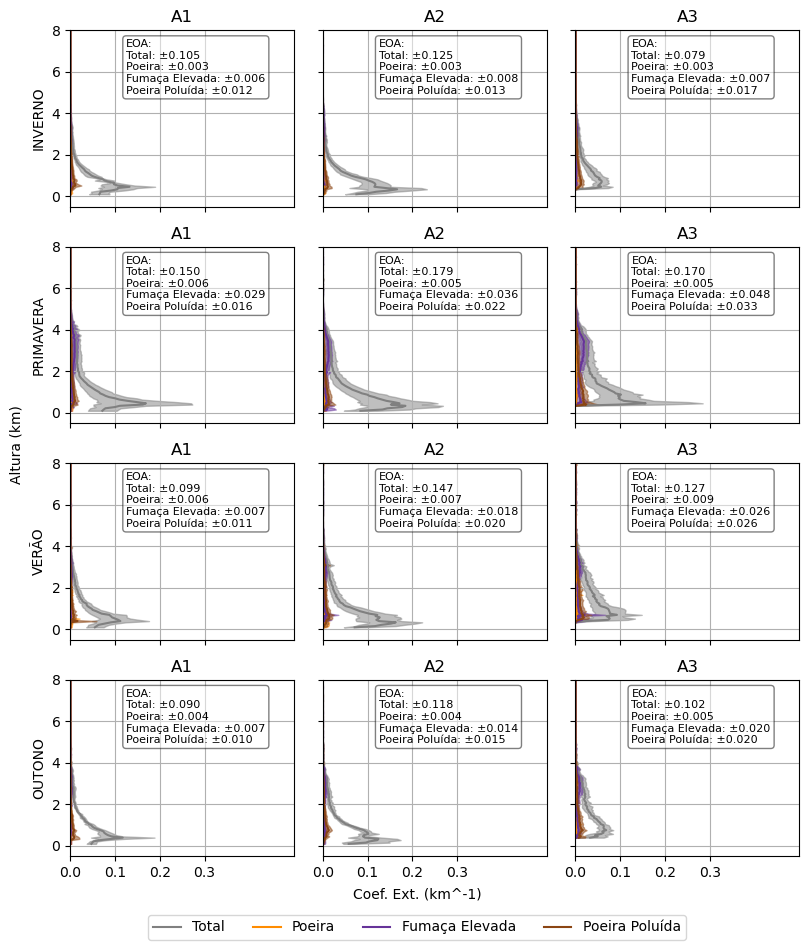

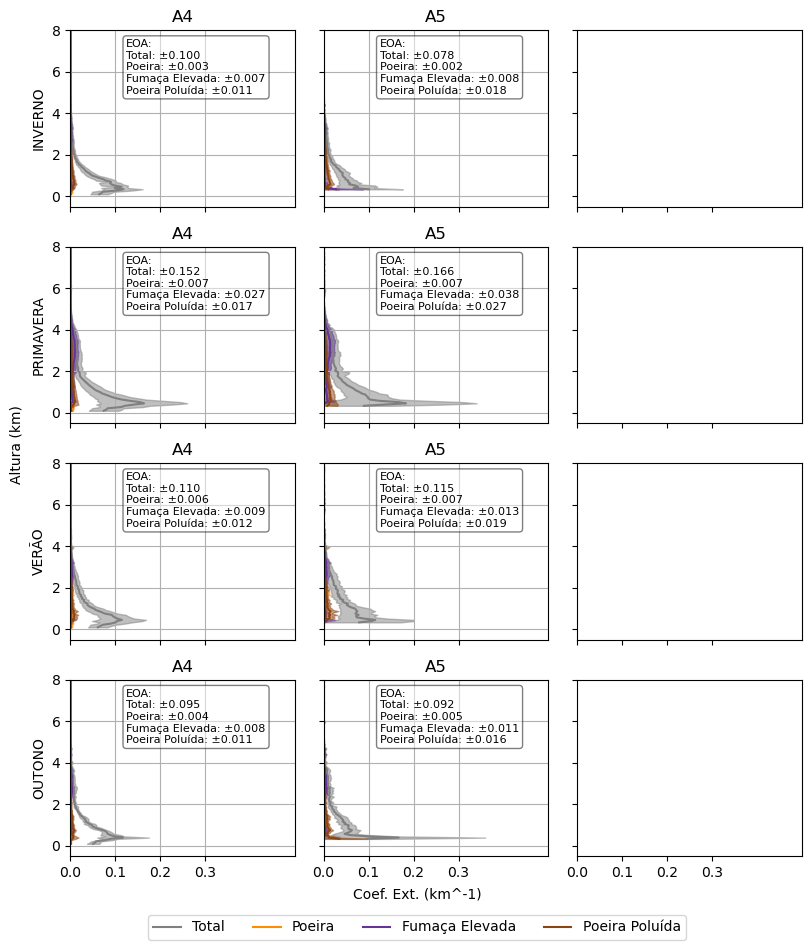

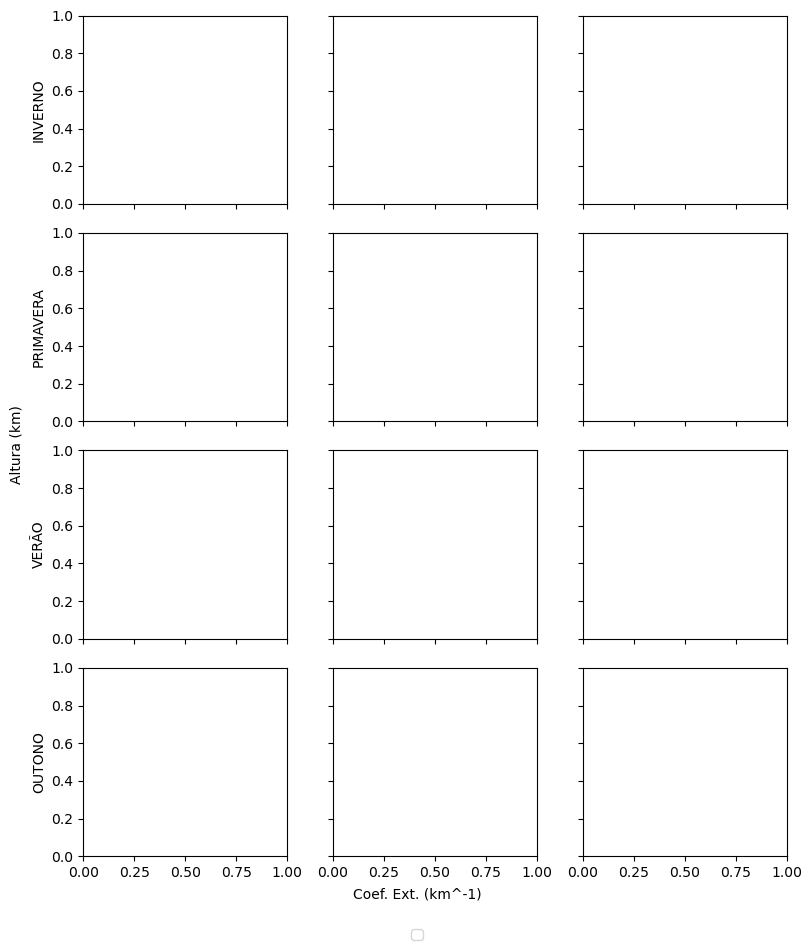

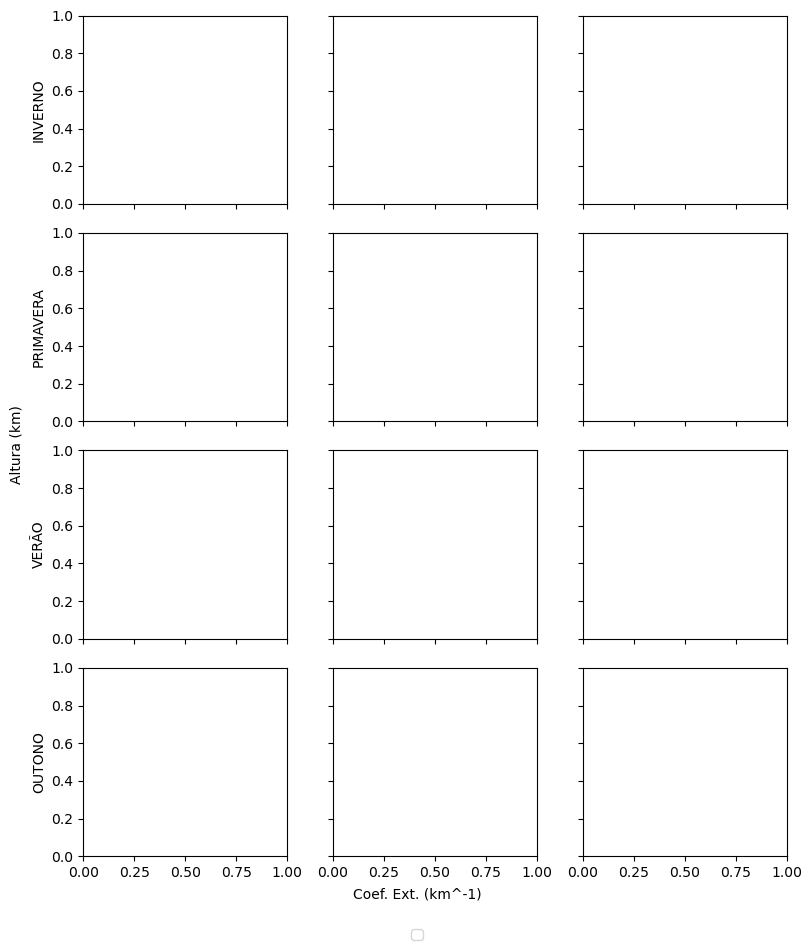

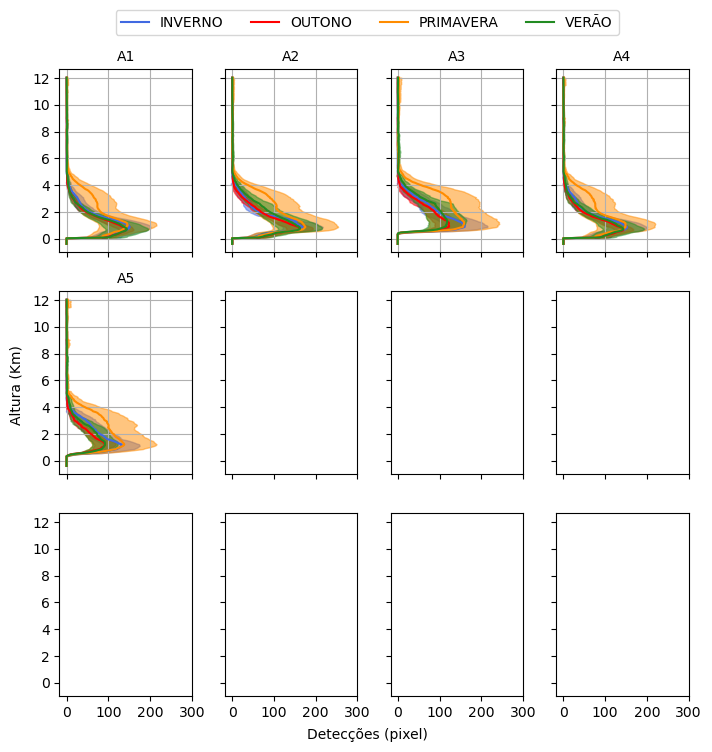

In [7]:
# Plots multiplas áreas
info_variaveis = info['Produtos']['Tropospheric_Aerosol_Profile']['Variáveis']
plots_multiplos_perfil_ce_eoa(perfil_media_sazonal, info_variaveis, niveis_altitude)
plot_multiplo_perfil_deteccao(perfil_media_sazonal, info_variaveis['Samples_Aerosol_Detected_Accepted'], niveis_altitude)

C:\Users\amori\Jupyter Notebook\OneDrive\LASA\Pasta_arquivos\plot_graficos.py:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(figsize=(4, 4), facecolor='white')


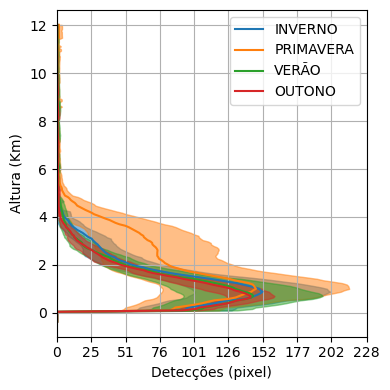

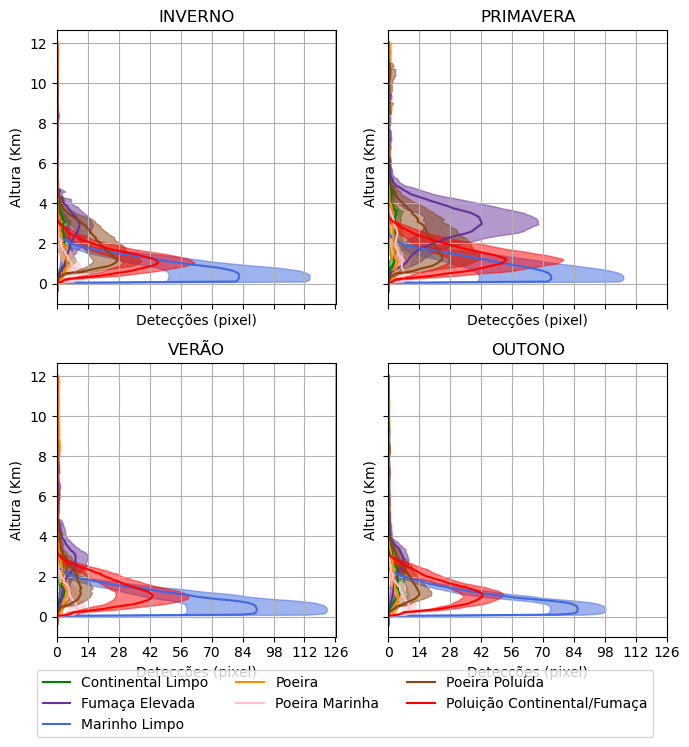

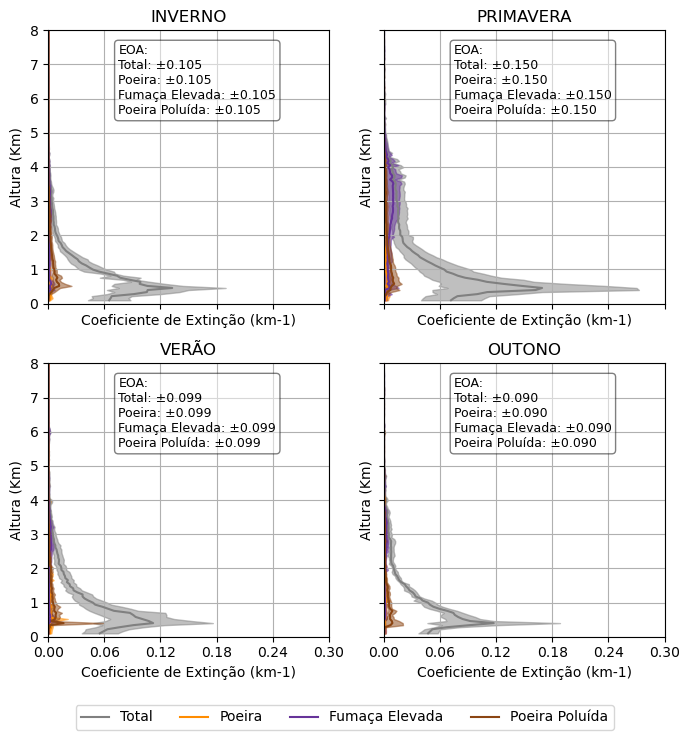

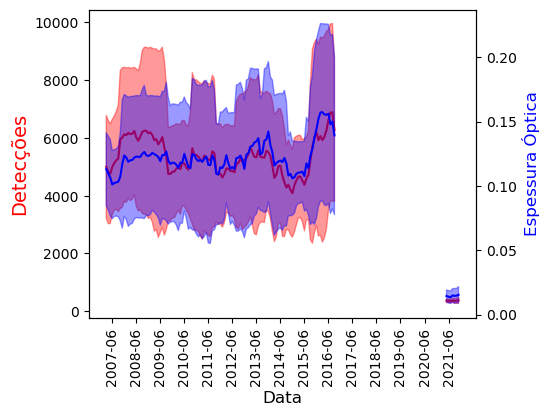

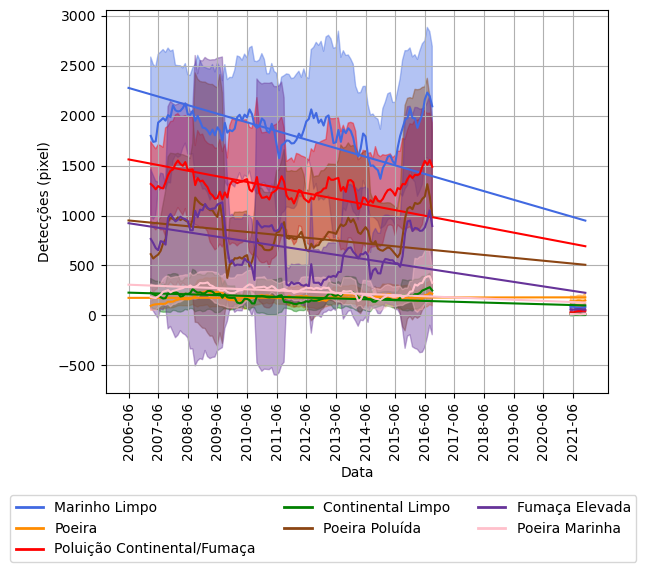

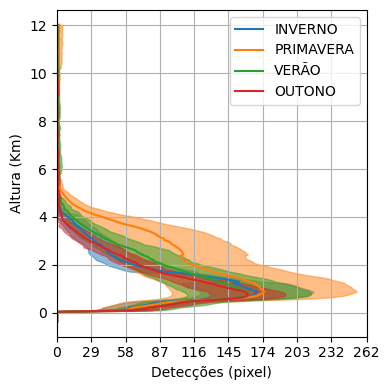

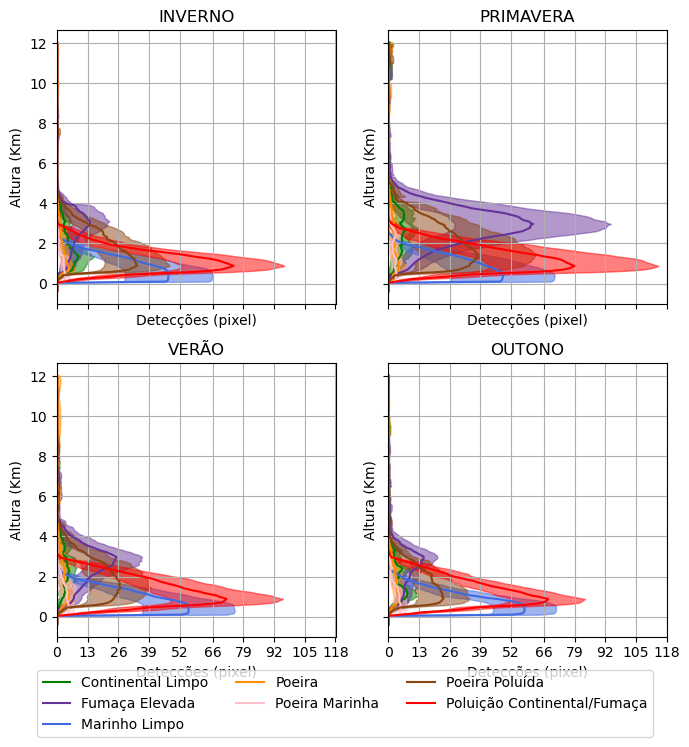

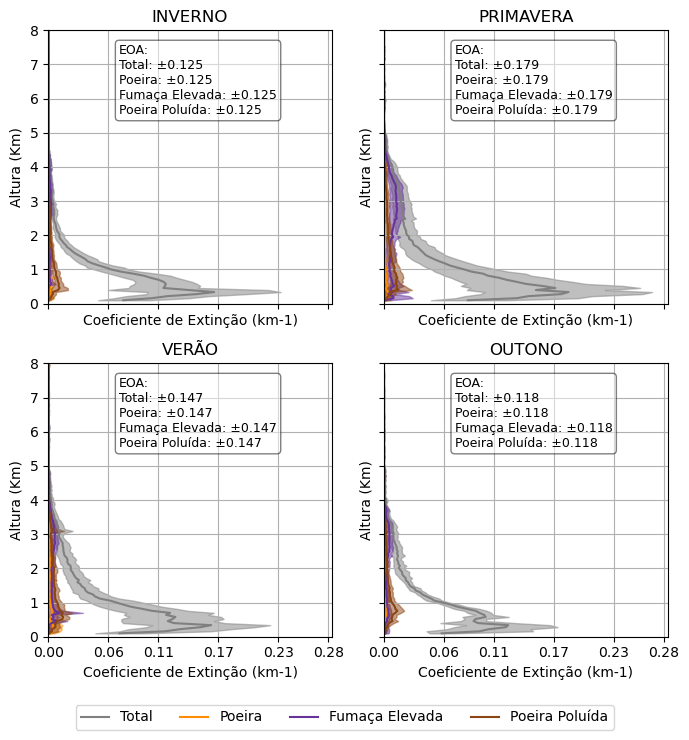

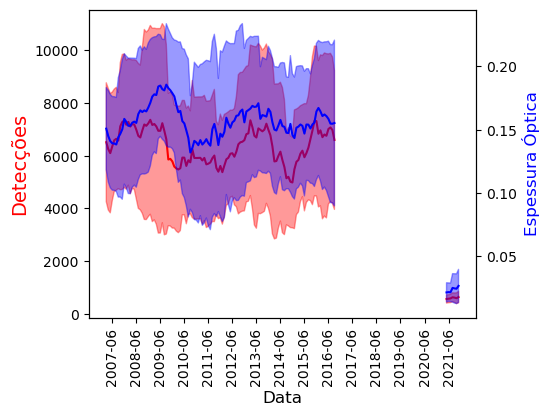

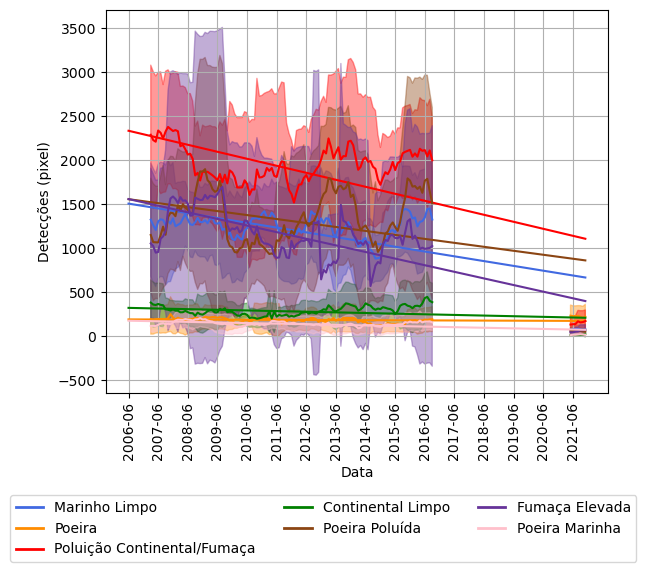

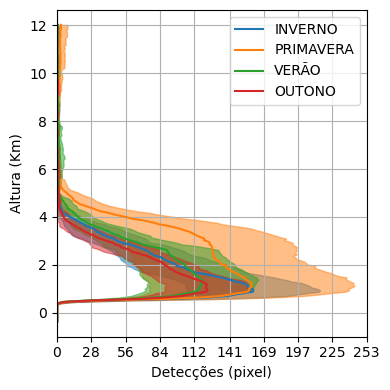

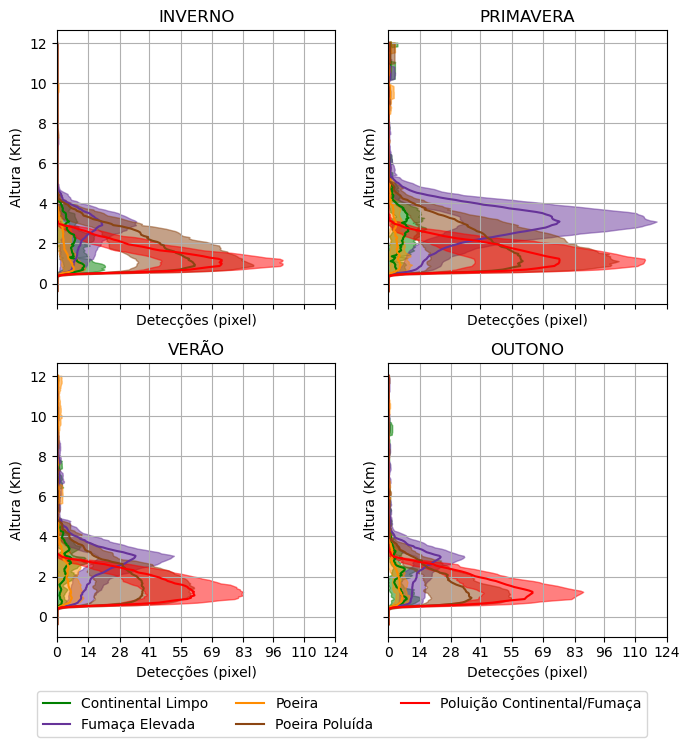

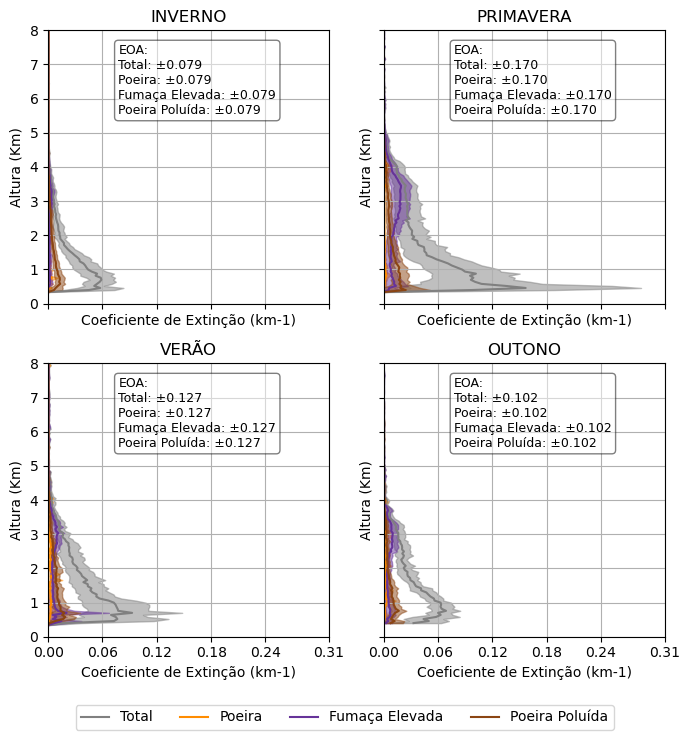

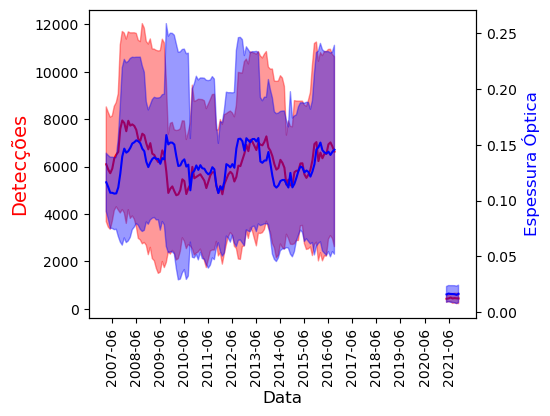

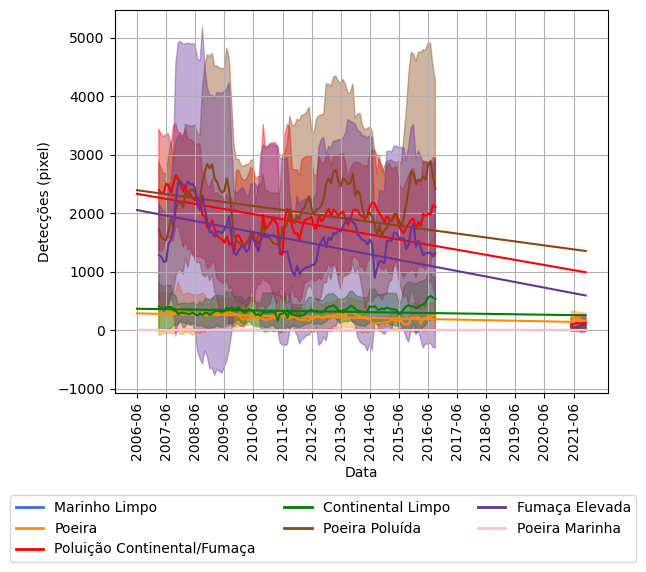

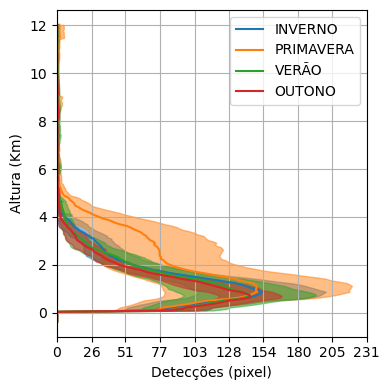

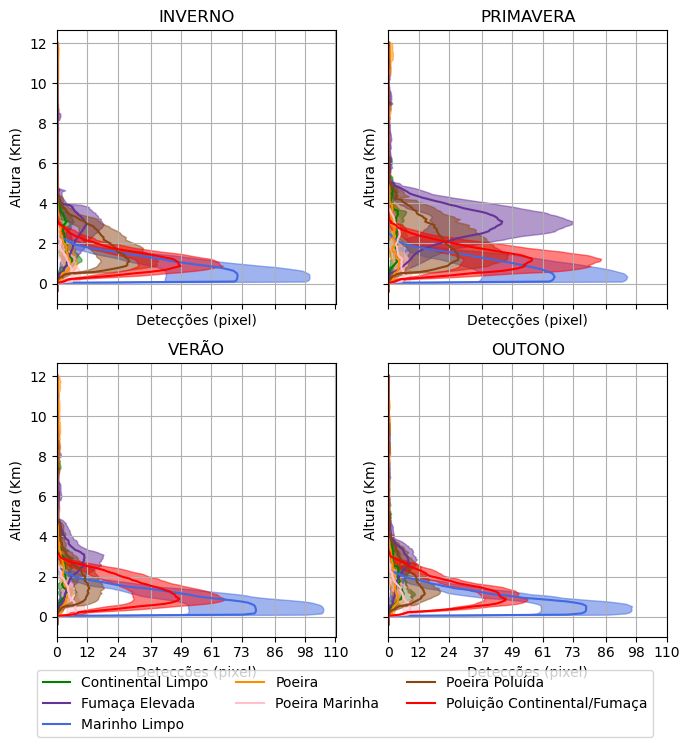

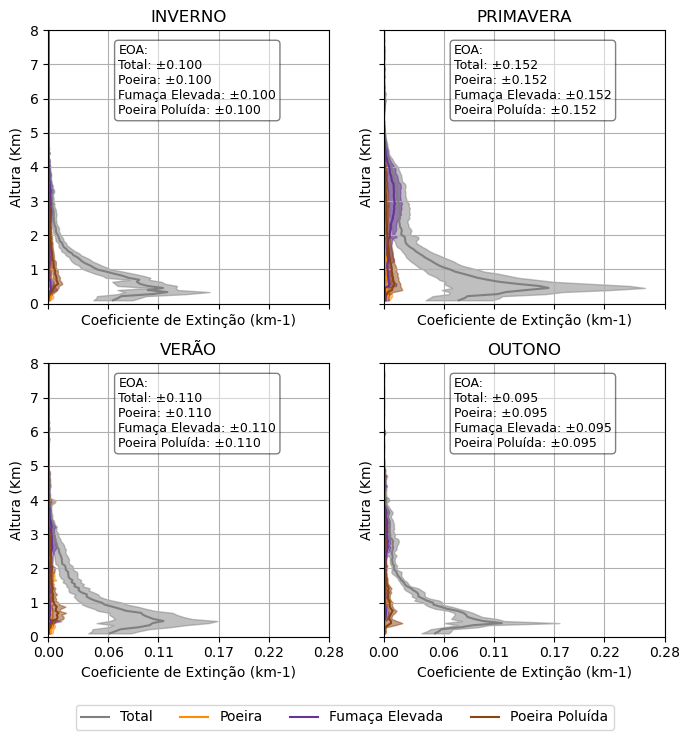

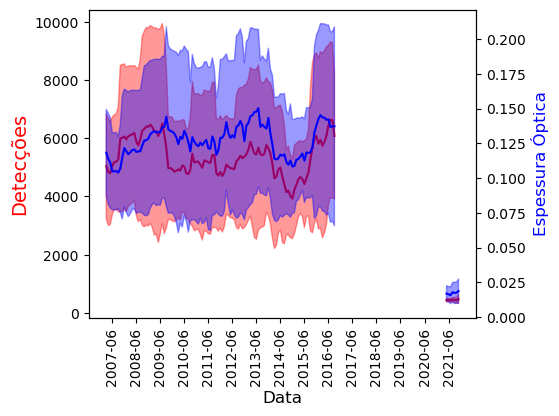

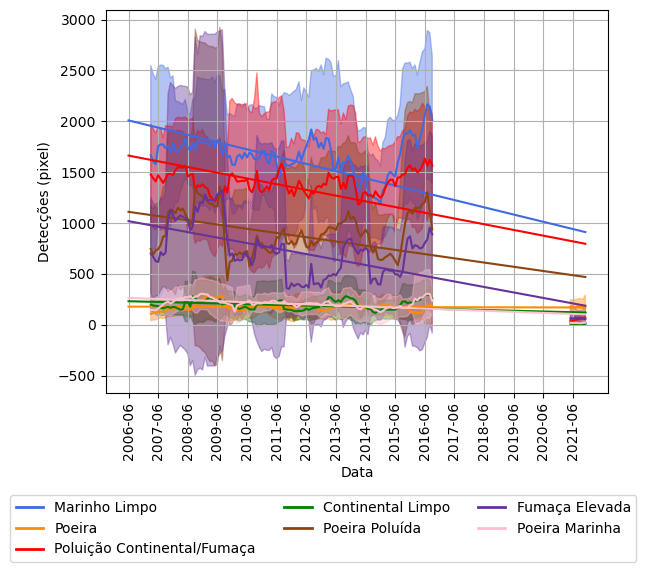

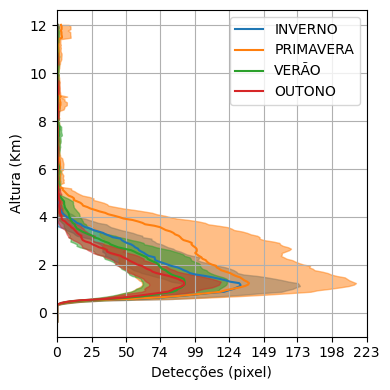

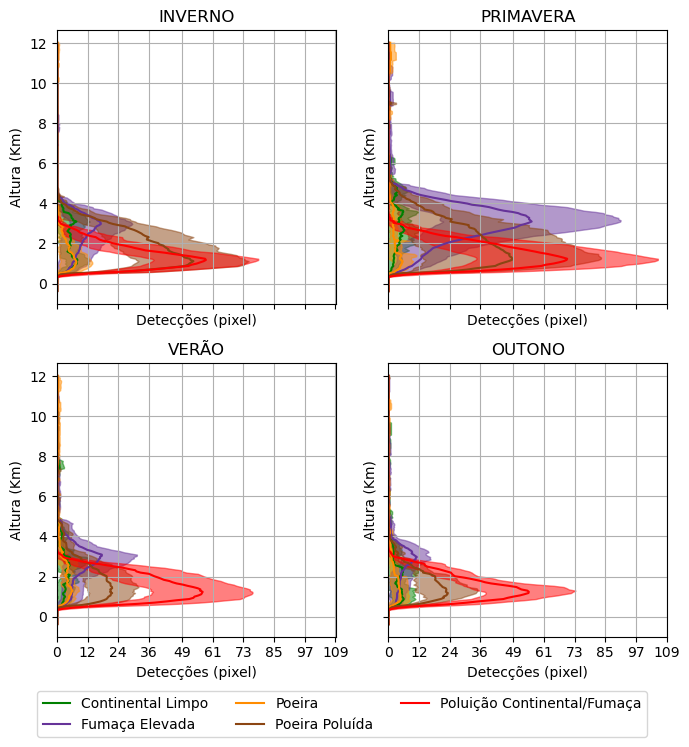

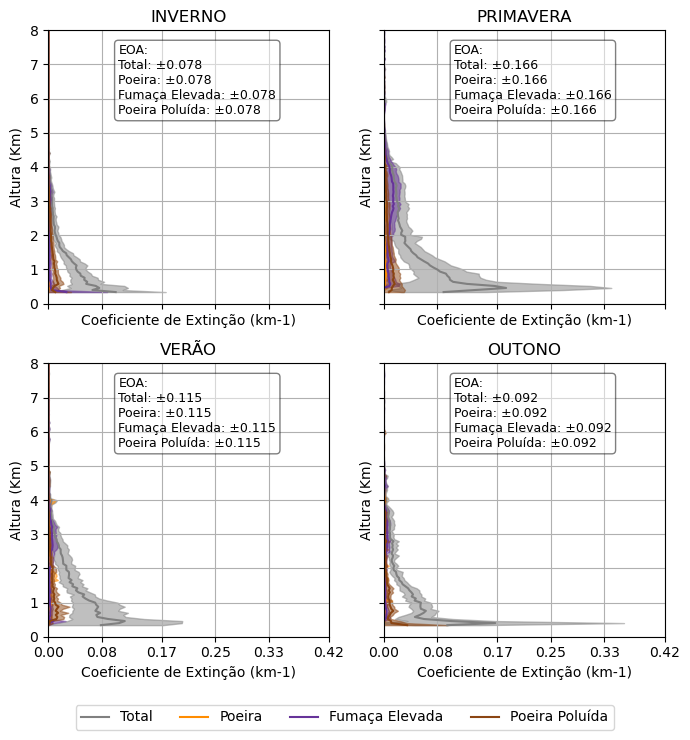

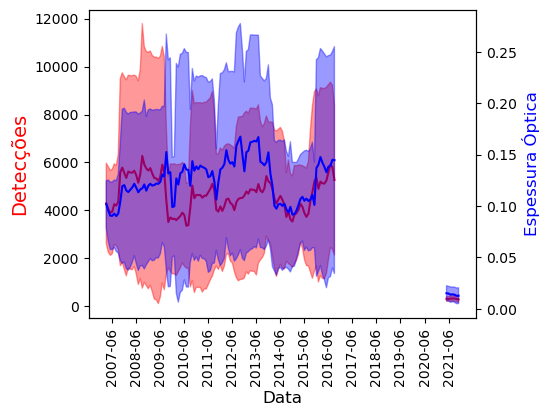

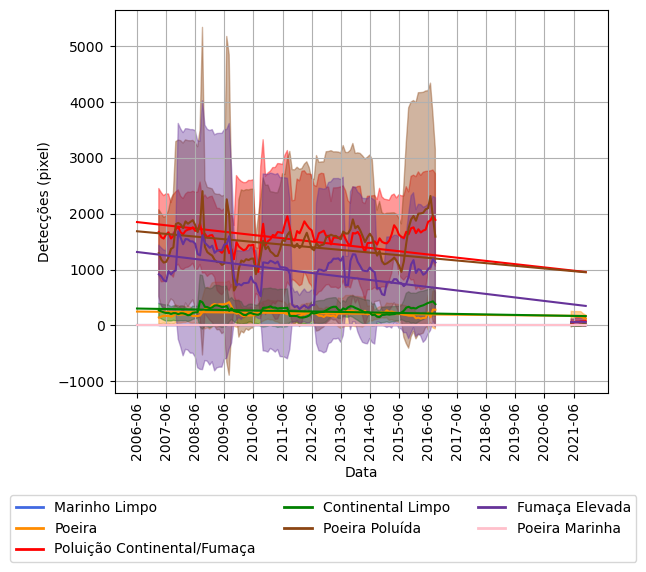

In [8]:
# Plots individuais por área
for area in dados.keys():
    plot_media_deteccoes_1d(perfil_media_sazonal[area]['Samples_Aerosol_Detected_Accepted'].copy().T, niveis_altitude, area)
    informacoes_variaveis = info['Produtos']['Tropospheric_Aerosol_Profile']['Variáveis']
    plot_deteccoes_sazonais_2d(perfil_media_sazonal[area]['Aerosol_Type'].copy().T, niveis_altitude, area, informacoes_variaveis['Aerosol_Type'])
    plot_coeficiente_extincao(perfil_media_sazonal[area].copy(), informacoes_variaveis, niveis_altitude, area)   
    plot_media_movel_deteccoes_eoa(dados[area]["Samples_Aerosol_Detected_Accepted"].copy(), dados[area]["AOD_Mean"].copy(), area)
    plot_media_movel_deteccoes_2d(dados[area]['Aerosol_Type'].copy(), info_variavel, area)
